<a href="https://colab.research.google.com/github/dennisli8246/Machine-Leaning/blob/main/Tensor_test_8_6_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用ResNet18模型進行圖片分類

本程式使用ResNet18來分類ants（螞蟻）與bees（蜜蜂）的圖片

準備蜜蜂與螞蟻的圖片檔案，下載：https://download.pytorch.org/tutorial/hymenoptera_data.zip


會有兩個檔案

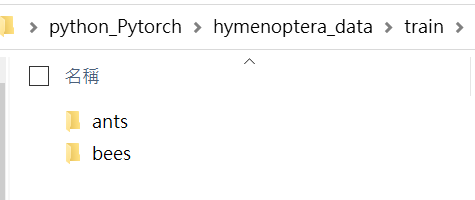

將檔案資料夾上傳到雲端
並且讓colab掛載

In [ ]:

from google.colab import drive#google colab會把檔案讀到google drive中 #沒有上傳才執行
# 將自己的雲端硬碟掛載上去
drive.mount('/content/drive')#連結自己的雲端硬碟
#img=Image.open("/content/drive/My Drive/Colab Notebooks/imgData/dog.jpg")#colab好像無法使用
#img.show()#colab好像無法使用

Mounted at /content/drive


step 1:匯入套件

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import torchvision
from torchvision import datasets,models
from torchvision import transforms
import matplotlib.pyplot as plt



step 2:設定亂數種子

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

step 3:定義訓練轉換函數


In [ ]:
train_transforms=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485,0.456,0.406],
        [0.229,0.224,0.225]
    )
])

說明：
* transforms.RandomResizedCrop(224): 將塗篇隨機剪裁為224x224
* transforms.RandomHorizontalFlip():將圖片隨機逕行水平翻轉，機率為0.5
* transforms.ToTensor() : 轉換為張量
* transforms.Normalize() : mean=[0.485,0.456,0.406],標準差=[0.229,0.224,0.225]，根據ILSVRC2012數據集間度數局中計算得


step 4:定義驗證轉換函數

In [ ]:
val_transforms=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485,0.456,0.406],
        [0.229,0.224,0.225]
    )
])

說明：

* transforms.Resize(256): 將圖面較短的邊長度變換為256
* transforms.CenterCrop(224):以中心裁減大小為224x224

step 5:以imageFolder建立訓練數據

In [ ]:
train_dataset=datasets.ImageFolder(
    root="/content/drive/My Drive/Colab Notebooks/hymenoptera_data/train",
    transform=train_transforms
)

step 6:以imageFolder建立驗證數據

In [ ]:
val_dataset=datasets.ImageFolder(
    root="/content/drive/My Drive/Colab Notebooks/hymenoptera_data/val",
    transform=val_transforms
)

step 7:建立訓練DataLoader

In [ ]:
train_loader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


step 8:建立驗證DataLoader

In [ ]:
val_loader=torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

step 9:載入預訓練模型

In [ ]:
model=models.resnet18(weights='ResNet18_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


step 10:印出模型輸出層

In [ ]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


step 11:修改fc層的架構,讓輸出層只有bees跟ants

In [ ]:
model.fc=nn.Linear(model.fc.in_features,2)
print(model.fc)

Linear(in_features=512, out_features=2, bias=True)


step 12: 設定device

In [ ]:
device='cuda'if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(device)

cpu


step 13: 定義損失函數及最佳化方法

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
#調整使用optimizer=adadelta(model.parameters(),lr=0.001)

step 14: 使用學習調度程序

In [ ]:
from torch.optim.lr_scheduler import StepLR
exp_lr_scheduler=StepLR(optimizer,step_size=7,gamma=0.1)

說明：
StepLR(optimizer,step_size=7,gamma=0.1)每七回合調整學習效率lr=lr*0.1

In [ ]:
model=models.resnet18(weights='ResNet18_Weights.DEFAULT')

print(model.fc)

model.fc=nn.Linear(model.fc.in_features,2)
print(model.fc)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=model.to(device)
print(device)

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

from torch.optim.lr_scheduler import StepLR
exp_lr_scheduler=StepLR(optimizer,step_size=7,gamma=0.1)

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=2, bias=True)
cpu


step 15: 訓練模型

In [ ]:
epochs=21
for epoch in range(epochs):
    model.train()
    losses=0.0
    corrects=0
    #批次訓練
    for inputs, labels in train_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)     #預測
        loss=criterion(outputs,labels)#計算損失
        loss.backward()
        optimizer.step()
        _,preds=torch.max(outputs,1)#取出最大索引值
        losses += loss.item()/inputs.size(0)#累加平均損失
        #累加準確率
        corrects += torch.sum(preds == labels.data)/inputs.size(0)

    #調整學習率
    exp_lr_scheduler.step()

    train_loss=losses/len(train_loader) #計算訓練損失
    train_acc=corrects/len(train_loader) #計算正確率

    model.eval()
    losses=0.0
    corrects=0

    #批次驗證
    for inputs,labels in val_loader:
      inputs=inputs.to(device)
      labels=labels.to(device)

      outputs=model(inputs)    #預測
      loss=criterion(outputs,labels)#計算損失

      _,preds=torch.max(outputs,1)#取出最大索引值
      losses += loss.item()/inputs.size(0)#累加平均損失
      #累加準確率
      corrects += torch.sum(preds == labels.data)/inputs.size(0)

    val_loss=losses/len(val_loader) #計算訓練損失
    val_acc=corrects.double()/len(val_loader) #計算正確率

    print(f"epoch:{epoch},Train_loss:{train_loss:.4f},acc:{train_acc:.4f},\
    val_loss:{val_loss:.4f},val_acc:{val_acc:.4f}")

epoch:0,Train_loss:0.1312,acc:0.7459,    val_loss:0.0752,val_acc:0.9038
epoch:1,Train_loss:0.1097,acc:0.8320,    val_loss:0.0942,val_acc:0.8333
epoch:2,Train_loss:0.1252,acc:0.7828,    val_loss:0.0866,val_acc:0.8269
epoch:3,Train_loss:0.1350,acc:0.7910,    val_loss:0.0574,val_acc:0.9038
epoch:4,Train_loss:0.1292,acc:0.8156,    val_loss:0.0631,val_acc:0.9038
epoch:5,Train_loss:0.1442,acc:0.8156,    val_loss:0.0699,val_acc:0.8974
epoch:6,Train_loss:0.1049,acc:0.8730,    val_loss:0.0581,val_acc:0.9231
epoch:7,Train_loss:0.1077,acc:0.8156,    val_loss:0.0506,val_acc:0.9295
epoch:8,Train_loss:0.0820,acc:0.8934,    val_loss:0.0580,val_acc:0.9295
epoch:9,Train_loss:0.0840,acc:0.8648,    val_loss:0.0480,val_acc:0.9295
epoch:10,Train_loss:0.0753,acc:0.8811,    val_loss:0.0437,val_acc:0.9487
epoch:11,Train_loss:0.0704,acc:0.8648,    val_loss:0.0477,val_acc:0.9423
epoch:12,Train_loss:0.0773,acc:0.8893,    val_loss:0.0709,val_acc:0.9167
epoch:13,Train_loss:0.0694,acc:0.8770,    val_loss:0.0508,val

In [ ]:
print(outputs.shape)

torch.Size([1, 2])


Step 16: 測試模型

In [ ]:
inputs, classes=next(iter(val_loader)) #取得一批圖片(4張)
class_name=val_dataset.classes

outputs=model(inputs.to(device))
_,preds=torch.max(outputs,1)
title=[class_name[x] for x in preds]

Step 17:顯示圖片及標籤：可以看到圖片上的文字與圖片為模型所預測的相同

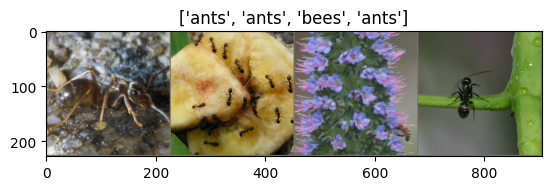

In [ ]:
import matplotlib.pyplot as plt

out=torchvision.utils.make_grid(inputs)
out=out.numpy().transpose((1,2,0))
mean=np.array([0.485,0.456,0.406])
std=np.array([0.229,0.224,0.225])
out = std*out+mean
out = np.clip(out,0,1)
plt.imshow(out)
if title is not None:
  plt.title(title)
plt.show()